# 🌀 Hurricane Ian WRF Analysis (No WRF-Python)
This notebook performs hurricane center detection and analysis **without using `wrf-python`**.

Steps:
1. Load WRF data.
2. Find the hurricane center from pressure, wind, and computed vorticity.
3. Create a vortex-centered coordinate system.
4. Compute radial and tangential wind components.
5. Plot results.

In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from pyproj import Proj, Transformer
from pathlib import Path

## 1️⃣ Load WRF Dataset

In [2]:
data_path = Path('data/wrfout_d03_2022-09-26_Ian2022_UNCPL.nc')
ds = nc.Dataset(data_path)
lat = ds.variables['XLAT'][0, :, :]
lon = ds.variables['XLONG'][0, :, :]
print(f"Loaded WRF file with shape: {lat.shape}")

print(len(ds.dimensions['Time']))
t = -1

Loaded WRF file with shape: (717, 669)
73


## 2️⃣ Find Hurricane Center (Surface Pressure Minimum)

In [3]:
psfc = ds.variables['PSFC'][t, :, :] / 100  # Pa → hPa
imin = np.unravel_index(np.argmin(psfc), psfc.shape)
center_lat_psfc, center_lon_psfc = float(lat[imin]), float(lon[imin])
print(f"Center (min PSFC): {center_lat_psfc:.2f}°, {center_lon_psfc:.2f}°")

# If not already done, open your WRF file (if not already loaded)
# ds = xr.open_dataset('wrfout_d03_2022-09-28_00:00:00')  # Example
# Replace with your actual file path or dataset variable

# Extract 2D lat/lon arrays
XLAT = ds.variables["XLAT"][0, :, :]
XLONG = ds.variables["XLONG"][0, :, :]


Center (min PSFC): 26.91°, -83.71°


## 3️⃣ Compute Approximate 850-hPa Vorticity Without `wrf-python`

In [4]:
# Approximate relative vorticity from 10-m winds for demonstration
u10 = ds.variables['U10'][t, :, :]
v10 = ds.variables['V10'][t, :, :]
deg2m = 111000  # rough conversion (1 degree ~ 111 km)
dy, dx = np.gradient(lat * deg2m, axis=0), np.gradient(lon * deg2m, axis=1)
dVdx = np.gradient(v10, axis=1) / (dx + 1e-9)
dUdy = np.gradient(u10, axis=0) / (dy + 1e-9)
f = 2 * 7.2921e-5 * np.sin(np.deg2rad(lat))  # Coriolis parameter
vort = dVdx - dUdy + f
imax = np.unravel_index(np.argmax(vort), vort.shape)
center_lat_vort, center_lon_vort = float(lat[imax]), float(lon[imax])
print(f"Center (max vorticity): {center_lat_vort:.2f}°, {center_lon_vort:.2f}°")

Center (max vorticity): 27.11°, -83.94°


## 4️⃣ Find Hurricane Center (10-m Wind Speed Minimum)

In [5]:
wind_speed = np.sqrt(u10**2 + v10**2)
imin_ws = np.unravel_index(np.argmin(wind_speed), wind_speed.shape)
center_lat_ws, center_lon_ws = float(lat[imin_ws]), float(lon[imin_ws])
print(f"Center (min 10-m wind): {center_lat_ws:.2f}°, {center_lon_ws:.2f}°")

Center (min 10-m wind): 27.94°, -81.71°


## 5️⃣ Create Vortex-Centered Azimuthal Equidistant Projection

In [6]:
center_lat, center_lon = center_lat_psfc, center_lon_psfc
aeqd = Proj(proj='aeqd', lat_0=center_lat, lon_0=center_lon, datum='WGS84')
transformer = Transformer.from_proj('epsg:4326', aeqd, always_xy=True)
x, y = transformer.transform(lon, lat)
r = np.sqrt(x**2 + y**2) / 1000  # km
theta = np.degrees(np.arctan2(y, x))
print('Computed storm-centered r and θ grids.')

Computed storm-centered r and θ grids.


## 6️⃣ Compute Radial and Tangential Wind Components

In [7]:
radial_wind =  u10 * np.cos(np.radians(theta)) + v10 * np.sin(np.radians(theta))
tangential_wind = -u10 * np.sin(np.radians(theta)) + v10 * np.cos(np.radians(theta))
print('Radial and tangential components computed.')

Radial and tangential components computed.


## 7️⃣ Plot Wind Speed, Vectors, and Center

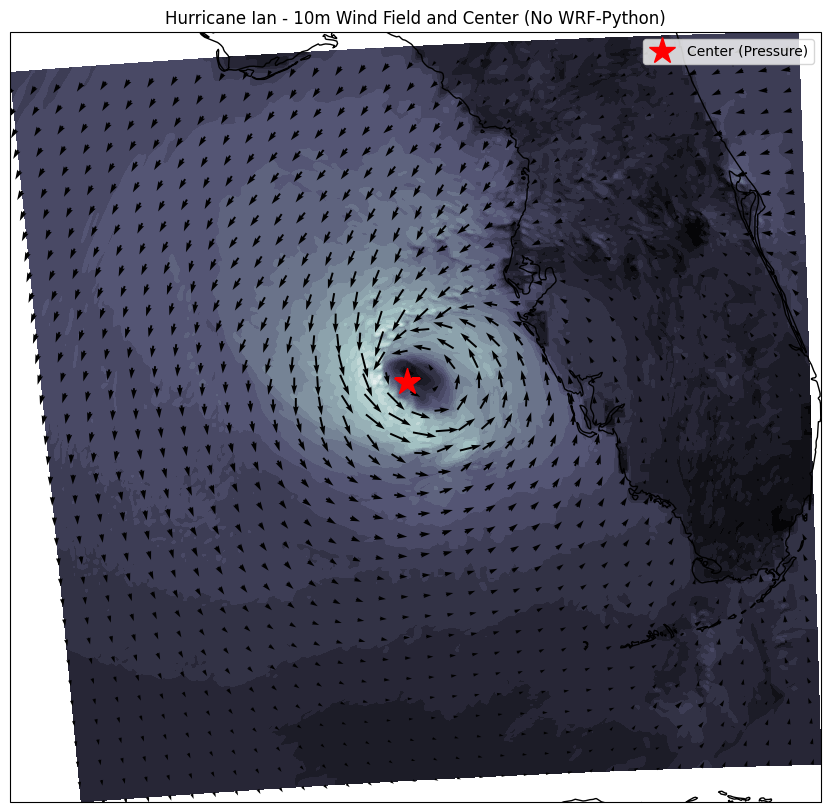

In [8]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.contourf(lon, lat, wind_speed, levels=np.linspace(0, 60, 21), cmap='bone')
ax.quiver(lon[::20,::20], lat[::20,::20], u10[::20,::20], v10[::20,::20], scale=1500)
ax.plot(center_lon, center_lat, 'r*', markersize=20, label='Center (Pressure)')
plt.legend()
plt.title('Hurricane Ian - 10m Wind Field and Center (No WRF-Python)')
plt.show()

Storm center: lat=26.91°, lon=-83.71°
U_inward shape: (33, 717, 669)


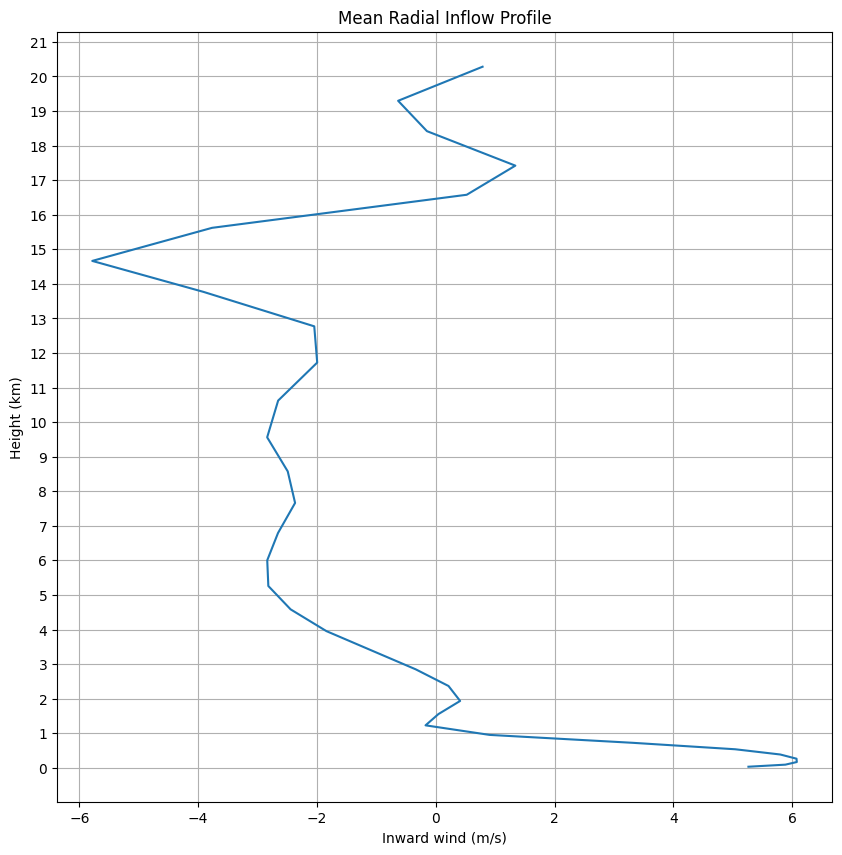

In [23]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

ds = xr.open_dataset(data_path)

# --- Extract surface pressure and coordinates ---
psfc = ds["PSFC"].isel(Time=t) / 100  # Pa → hPa
XLAT = ds["XLAT"].isel(Time=t).values
XLONG = ds["XLONG"].isel(Time=t).values

# --- Find storm center (min surface pressure) ---
imin = np.unravel_index(np.argmin(psfc.values), psfc.shape)
yc, xc = imin
center_lat, center_lon = XLAT[yc, xc], XLONG[yc, xc]
print(f"Storm center: lat={center_lat:.2f}°, lon={center_lon:.2f}°")

# --- Unstagger U and V ---
U_stag = ds["U"].isel(Time=t)
V_stag = ds["V"].isel(Time=t)

# Average to destagger
U = 0.5 * (U_stag.isel(west_east_stag=slice(0, -1)) +
           U_stag.isel(west_east_stag=slice(1, None)))

V = 0.5 * (V_stag.isel(south_north_stag=slice(0, -1)) +
           V_stag.isel(south_north_stag=slice(1, None)))

U = U.values
V = V.values

# --- Compute distance and radial vectors ---
Re = 6371e3  # Earth radius (m)
dx = (XLONG - XLONG[yc, xc]) * np.cos(np.deg2rad(XLAT)) * (np.pi / 180) * Re
dy = (XLAT - XLAT[yc, xc]) * (np.pi / 180) * Re
r = np.sqrt(dx**2 + dy**2)
r[r == 0] = np.nan

ur = dx / r
vr = dy / r

# --- Compute inward wind component (positive toward center) ---
U_radial = U * ur + V * vr
U_inward = -U_radial

print("U_inward shape:", U_inward.shape)

# --- Compute height field ---
z = (ds["PH"].isel(Time=t) + ds["PHB"].isel(Time=t)) / 9.81  # m

# --- Compute vertical inflow profile (e.g., 50–300 km annulus) ---
rmin, rmax = 50e3, 300e3
mask = (r >= rmin) & (r <= rmax)

# Geopotential height on W-levels
z_stag = ((ds["PH"].isel(Time=t) + ds["PHB"].isel(Time=t)) / 9.81).values

# Destagger to mass levels (average adjacent levels)
z = 0.5 * (z_stag[1:, :, :] + z_stag[:-1, :, :])


mean_inflow = np.nanmean(U_inward[:, mask], axis=1)
mean_height = np.nanmean(z[:, mask], axis=1)

plt.figure(figsize=(10, 10))
plt.plot(mean_inflow, mean_height / 1000)

ymax = np.nanmax(mean_height) / 1000
plt.yticks(np.arange(0, ymax + 1, 1))

plt.xlabel("Inward wind (m/s)")
plt.ylabel("Height (km)")
plt.title("Mean Radial Inflow Profile")
plt.grid(True)
plt.show()


In [24]:
import numpy as np

# constants
cp = 1004.0         # J kg-1 K-1
Lv = 2.5e6          # J kg-1
Rd = 287.05         # J kg-1 K-1

# choose time t and annulus / inflow vertical layer
t = 0
rmin, rmax = 0.0, 50e3    # example: inflow layer radial extent (m) from center; adjust as needed
z_top = 1000.0            # inflow layer top in meters (e.g., 1000 m for lowest 1 km)

# --- get previously computed: U_inward (shape: [z, y, x]) (positive toward center) ---
# U_inward = ... (from your earlier code)
# r (2D radial distance), mask (2D) already defined; ensure r is in meters

# horizontal mask for annulus (True where we include horizontal cells)
horiz_mask = (r >= rmin) & (r <= rmax)

# vertical selection: create a boolean mask of model levels that are within inflow layer height
# First compute level heights (destaggered) as you did:
z_stag = ((ds['PH'].isel(Time=t) + ds['PHB'].isel(Time=t)) / 9.81).values    # shape (bottom_top_stag, ny, nx)
z = 0.5*(z_stag[1:,...] + z_stag[:-1,...])  # destagger -> shape (bottom_top, ny, nx), heights in m

# Build a vertical-level mask (select levels whose mean height < z_top)
vert_mask = (np.nanmean(z, axis=(1,2)) <= z_top)   # boolean array per level
# Alternatively to be area-aware: vert_mask = np.nanmean(z[:, horiz_mask], axis=1) <= z_top

# Now create full 3D mask
mask3d = np.zeros_like(U_inward, dtype=bool)
mask2d = horiz_mask   # shape (ny, nx)
for k in range(U_inward.shape[0]):
    if vert_mask[k]:
        mask3d[k, :, :] = mask2d

# --- Get temperature T and specific humidity qv on mass levels ---
# Use 2D/3D variables available in your file:
# For 3D T you may have ds['T'] (check whether it's full temp or perturbation). 
# Safer: if ds provides 'T' as full in K, use it; otherwise compute T from theta & pressure.
# Many WRF files have T (perturbation potential temp) → check your variable docs.
T3d = ds['T'].isel(Time=t).values   # ASSUMPTION: T is absolute temperature (K). If not, adjust accordingly.
qv3d = ds['QVAPOR'].isel(Time=t).values  # (kg/kg)

# If ds['T'] is perturbation theta, you must create real temperature; adjust as needed.

# --- Pressure (total) on mass levels ---
# Total pressure often = P + PB (both in Pa), but check your variables:
p3d = (ds['P'].isel(Time=t) + ds['PB'].isel(Time=t)).values   # Pa

# --- Air density (rho) ---
rho3d = p3d / (Rd * T3d)   # kg m-3

# --- Specific enthalpy h = cp*T + Lv*qv (J/kg) ---
h3d = cp * T3d + Lv * qv3d

# --- Horizontal cell area A (m^2) ---
# Prefer ds['AREA2D'] if available (2D area), else compute dx*dy
if 'AREA2D' in ds:
    A2d = ds['AREA2D'].isel(Time=t).values   # sometime AREA2D exists (m2)
    # but AREA2D may be 2D only; use it for each level
else:
    # compute approximate cell area from grid spacing (note: uses spherical approx)
    # compute grid spacing in meters from lon/lat if needed. Simpler: use DX and DY global attributes if present:
    dx = float(ds.attrs.get('DX', np.nan))   # meters
    dy = float(ds.attrs.get('DY', np.nan))
    A2d = dx * dy * np.ones_like(r)          # fallback

# broadcast A2d to 3D to match U_inward
A3d = np.broadcast_to(A2d, U_inward.shape)

# --- Mass flux inward per grid cell (kg/s) ---
# U_inward is m/s (positive toward center), rho3d kg/m3, A3d m2 → mass flux kg/s
mass_flux = rho3d * U_inward * A3d    # note: sign: positive = mass toward center

# only keep inflow-layer cells (mask3d)
mass_flux_masked = np.where(mask3d, mass_flux, 0.0)
h_masked = np.where(mask3d, h3d, 0.0)

# --- Enthalpy transport through each cell (W) ---
E_dot_grid = mass_flux_masked * h_masked   # kg/s * J/kg = W

# --- Total enthalpy transport into storm through inflow layer (W) ---
total_enthalpy_transport_W = np.nansum(E_dot_grid)
print("Total enthalpy transport into storm (W):", total_enthalpy_transport_W)

# Optional: convert to TW or W/m2 by dividing by area used, etc.


Total enthalpy transport into storm (W): -5.903998e+19


In [ ]:
# use U10/V10 to compute radial component at 10m
if ('U10' in ds) and ('V10' in ds):
    U10 = ds['U10'].isel(Time=t).values
    V10 = ds['V10'].isel(Time=t).values
    # compute radial unit vectors ur,vr (you already have)
    U10_radial = U10 * ur + V10 * vr   # outward positive
    U10_inward = -U10_radial           # inward positive
    # use T2 and Q2 for enthalpy and p_sfc ~ PSFC
    T2 = ds['T2'].isel(Time=t).values     # 2 m temperature in K? check units
    Q2 = ds['Q2'].isel(Time=t).values     # 2 m specific humidity (kg/kg)
    p_sfc = ds['PSFC'].isel(Time=t).values
    rho_sfc = p_sfc / (Rd * T2)
    h2 = 1004.0 * T2 + 2.5e6 * Q2
    # mass flux per cell at surface (kg/s)
    mass_flux_surface = rho_sfc * U10_inward * A2d
    # positive toward center only
    inward_mask_surface = (mask2d) & (mass_flux_surface > 0)
    total_inward_E_surface = np.nansum(mass_flux_surface[inward_mask_surface] * h2[inward_mask_surface])
    print("Surface-proxy total inward enthalpy transport (W):", total_inward_E_surface)
else:
    print("U10/V10/T2/Q2 not all present; cannot compute near-surface proxy.")


Selected inflow levels (indices): [0 1 2 3 4 5 6 7]
Heights (m) of those levels: [ 30.194063  90.62126  167.60988  265.18793  388.01492  541.3057
 730.6371   961.6019  ]
INFLOW-LAYER TOP (m): 1000.0
Number of horizontal cells in annulus: 7645
Number of 3D inflow cells counted: 33311
Total inward mass flux (kg/s) [limited layer]: 5.4781497e+11
Total inward enthalpy transport (W) [limited layer]: 1.9007232e+17
Total inward enthalpy transport (TW) [limited layer]: 190072.31
Integrated surface H_surf over annulus (W): 0.0
Mean H_surf over annulus (W m-2): 0.0
Ratio (inflow enthalpy [W] / surface H_total [W]): inf
Annulus area (m2): 7.6449997e+09
Inward enthalpy flux per unit area (W m-2): 2.4862306e+07


C:\Users\ustro\AppData\Local\Temp\ipykernel_23420\1466465603.py:56: RuntimeWarning: overflow encountered in scalar divide
  total_inward_E_new / (H_total_annulus + 1e-30))  # +tiny to avoid zero-division


In [32]:
import numpy as np

# user choices
r_bins = np.arange(0, 301e3, 10e3)   # 0–300 km in 10-km bins (adjust as desired)
levels = levels_inflow               # indices of levels <= z_top (you already built this)
Acell = A2d                          # (ny,nx) cell area in m2
nz, ny, nx = U_inward.shape

# compute radius at each horizontal cell (2D) 'r' must be in meters relative to center
r2d = r

# precompute 3D mass_flux_inward (only positive inward counts)
mass_flux3d = rho3d * U_inward * np.broadcast_to(Acell, U_inward.shape)  # kg/s per cell
enthalpy_flux3d = mass_flux3d * h3d                                         # W per cell

# restrict to chosen vertical inflow layers
mask_vert = np.zeros_like(U_inward, dtype=bool)
mask_vert[levels,:,:] = True

# radial bin totals
bin_centers = 0.5*(r_bins[:-1] + r_bins[1:])
E_per_bin = np.zeros(len(bin_centers))
mass_per_bin = np.zeros(len(bin_centers))
area_per_bin = np.zeros(len(bin_centers))

for ib in range(len(bin_centers)):
    rb0, rb1 = r_bins[ib], r_bins[ib+1]
    horiz_mask = (r2d >= rb0) & (r2d < rb1) & mask2d   # only annulus & original mask2d
    if np.count_nonzero(horiz_mask) == 0:
        continue
    horiz3d = np.broadcast_to(horiz_mask, U_inward.shape)
    select_mask = horiz3d & mask_vert & (mass_flux3d > 0)  # only inward-directed
    E_per_bin[ib] = np.nansum(np.where(select_mask, enthalpy_flux3d, 0.0))
    mass_per_bin[ib] = np.nansum(np.where(select_mask, mass_flux3d, 0.0))
    area_per_bin[ib] = np.nansum(Acell[horiz_mask])

# per-meter-of-perimeter (approx perimeter ~ 2π * r_center)
perimeter = 2 * np.pi * bin_centers
E_per_m = E_per_bin / (perimeter + 1e-30)   # W per meter

# print compact table
for ib, rc in enumerate(bin_centers):
    print(f"Bin {r_bins[ib]/1e3:.0f}-{r_bins[ib+1]/1e3:.0f} km: E = {E_per_bin[ib]:.3e} W, mass = {mass_per_bin[ib]:.3e} kg/s, area = {area_per_bin[ib]:.3e} m2, E/m = {E_per_m[ib]:.3e} W/m")


Bin 0-10 km: E = 3.035e+15 W, mass = 8.723e+09 kg/s, area = 3.000e+08 m2, E/m = 9.660e+10 W/m
Bin 10-20 km: E = 9.886e+15 W, mass = 2.845e+10 kg/s, area = 9.200e+08 m2, E/m = 1.049e+11 W/m
Bin 20-30 km: E = 2.167e+16 W, mass = 6.225e+10 kg/s, area = 1.528e+09 m2, E/m = 1.380e+11 W/m
Bin 30-40 km: E = 5.518e+16 W, mass = 1.588e+11 kg/s, area = 2.145e+09 m2, E/m = 2.509e+11 W/m
Bin 40-50 km: E = 1.003e+17 W, mass = 2.896e+11 kg/s, area = 2.752e+09 m2, E/m = 3.547e+11 W/m
Bin 50-60 km: E = 0.000e+00 W, mass = 0.000e+00 kg/s, area = 0.000e+00 m2, E/m = 0.000e+00 W/m
Bin 60-70 km: E = 0.000e+00 W, mass = 0.000e+00 kg/s, area = 0.000e+00 m2, E/m = 0.000e+00 W/m
Bin 70-80 km: E = 0.000e+00 W, mass = 0.000e+00 kg/s, area = 0.000e+00 m2, E/m = 0.000e+00 W/m
Bin 80-90 km: E = 0.000e+00 W, mass = 0.000e+00 kg/s, area = 0.000e+00 m2, E/m = 0.000e+00 W/m
Bin 90-100 km: E = 0.000e+00 W, mass = 0.000e+00 kg/s, area = 0.000e+00 m2, E/m = 0.000e+00 W/m
Bin 100-110 km: E = 0.000e+00 W, mass = 0.000e+00 

C:\Users\ustro\AppData\Local\Temp\ipykernel_23420\695739072.py:48: RuntimeWarning: invalid value encountered in divide
  E_per_area = np.where(area_per_bin>0, E_per_bin / area_per_bin, 0.0)  # W m-2


Total enthalpy transport (W) inside 100 km: 1.901e+17 W
Total mass flux (kg/s) inside 100 km: 5.478e+11 kg/s
Annulus total area inside 100 km: 7.645e+09 m^2
Radius of max E_per_m: 45.00 km with E_per_m = 3.547e+11 W/m
Top radial bins (center_km, E [W], E/m [W/m], E/area [W/m2], mass [kg/s], area [m2], cells):
    5 km: E=3.035e+15, E/m=9.660e+10, E/area=1.012e+07, mass=8.723e+09, area=3.000e+08, cells=300
   15 km: E=9.886e+15, E/m=1.049e+11, E/area=1.075e+07, mass=2.845e+10, area=9.200e+08, cells=920
   25 km: E=2.167e+16, E/m=1.380e+11, E/area=1.418e+07, mass=6.225e+10, area=1.528e+09, cells=1528
   35 km: E=5.518e+16, E/m=2.509e+11, E/area=2.573e+07, mass=1.588e+11, area=2.145e+09, cells=2145
   45 km: E=1.003e+17, E/m=3.547e+11, E/area=3.644e+07, mass=2.896e+11, area=2.752e+09, cells=2752


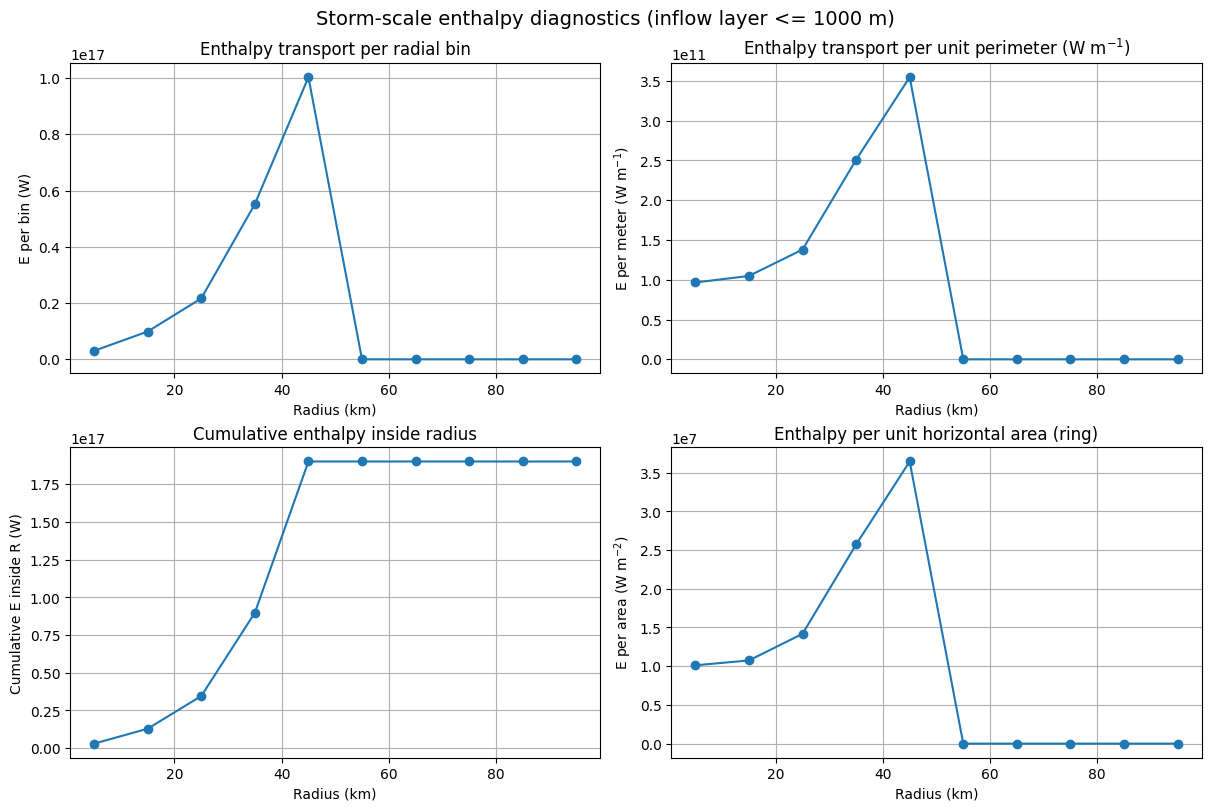

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# user choices
Rmax = 100e3            # maximum radius to show (m). set to 300e3 if you like
dr = 10e3               # radial bin width (m)
z_top = 1000.0          # inflow layer top (m) — use same as before
levels = levels_inflow  # indices of levels <= z_top (you computed earlier)

# ensure we have required arrays: r (2D, m), mask2d (2D horizontal bool), A2d (2D m2)
r2d = r.copy()          # meters from center
Acell = A2d
nz, ny, nx = U_inward.shape

# compute mass_flux3d and enthalpy_flux3d if not present
mass_flux3d = rho3d * U_inward * np.broadcast_to(Acell, U_inward.shape)   # kg/s per cell (signed)
enthalpy_flux3d = mass_flux3d * h3d                                       # W per cell (signed)

# build vertical mask for inflow layer
mask_vert = np.zeros_like(U_inward, dtype=bool)
mask_vert[levels,:,:] = True

# radial bins
r_bins = np.arange(0, Rmax + dr, dr)
bin_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
nbins = len(bin_centers)

E_per_bin = np.zeros(nbins)
mass_per_bin = np.zeros(nbins)
area_per_bin = np.zeros(nbins)
count_cells = np.zeros(nbins, dtype=int)

for ib in range(nbins):
    rb0, rb1 = r_bins[ib], r_bins[ib+1]
    horiz_mask = (r2d >= rb0) & (r2d < rb1) & mask2d
    if np.count_nonzero(horiz_mask) == 0:
        continue
    horiz3d = np.broadcast_to(horiz_mask, U_inward.shape)
    select_mask = horiz3d & mask_vert & (mass_flux3d > 0)   # only inward-directed mass flux
    E_per_bin[ib] = np.nansum(np.where(select_mask, enthalpy_flux3d, 0.0))
    mass_per_bin[ib] = np.nansum(np.where(select_mask, mass_flux3d, 0.0))
    area_per_bin[ib] = np.nansum(Acell[horiz_mask])
    count_cells[ib] = np.count_nonzero(horiz_mask)

# derived metrics
perimeter = 2 * np.pi * bin_centers
E_per_m = np.where(perimeter>0, E_per_bin / (perimeter), 0.0)   # W per meter
E_per_area = np.where(area_per_bin>0, E_per_bin / area_per_bin, 0.0)  # W m-2
cumE = np.cumsum(E_per_bin)  # cumulative enthalpy inside radius bins (W)

# find bin with max E_per_m (useful metric)
ib_max = np.nanargmax(E_per_m)
r_at_max = bin_centers[ib_max]
E_per_m_max = E_per_m[ib_max]

# print compact table for important ranges
print(f"Total enthalpy transport (W) inside {Rmax/1000:.0f} km: {np.nansum(E_per_bin):.3e} W")
print(f"Total mass flux (kg/s) inside {Rmax/1000:.0f} km: {np.nansum(mass_per_bin):.3e} kg/s")
print(f"Annulus total area inside {Rmax/1000:.0f} km: {np.nansum(area_per_bin):.3e} m^2")
print(f"Radius of max E_per_m: {r_at_max/1000:.2f} km with E_per_m = {E_per_m_max:.3e} W/m")
print("Top radial bins (center_km, E [W], E/m [W/m], E/area [W/m2], mass [kg/s], area [m2], cells):")
for ib in range(nbins):
    if area_per_bin[ib] == 0: 
        continue
    print(f"{bin_centers[ib]/1000:5.0f} km: E={E_per_bin[ib]:.3e}, E/m={E_per_m[ib]:.3e}, E/area={E_per_area[ib]:.3e}, mass={mass_per_bin[ib]:.3e}, area={area_per_bin[ib]:.3e}, cells={count_cells[ib]}")

# --- PLOTS ---
fig, axs = plt.subplots(2,2, figsize=(12,8), constrained_layout=True)

ax = axs[0,0]
ax.plot(bin_centers/1000, E_per_bin, marker='o')
ax.set_xlabel('Radius (km)'); ax.set_ylabel('E per bin (W)')
ax.set_title('Enthalpy transport per radial bin')
ax.grid(True)

ax = axs[0,1]
ax.plot(bin_centers/1000, E_per_m, marker='o')
ax.set_xlabel('Radius (km)'); ax.set_ylabel('E per meter (W m$^{-1}$)')
ax.set_title('Enthalpy transport per unit perimeter (W m$^{-1}$)')
ax.grid(True)

ax = axs[1,0]
ax.plot(bin_centers/1000, cumE, marker='o')
ax.set_xlabel('Radius (km)'); ax.set_ylabel('Cumulative E inside R (W)')
ax.set_title('Cumulative enthalpy inside radius')
ax.grid(True)

ax = axs[1,1]
ax.plot(bin_centers/1000, E_per_area, marker='o')
ax.set_xlabel('Radius (km)'); ax.set_ylabel('E per area (W m$^{-2}$)')
ax.set_title('Enthalpy per unit horizontal area (ring)')
ax.grid(True)

plt.suptitle('Storm-scale enthalpy diagnostics (inflow layer <= {:.0f} m)'.format(z_top), fontsize=14)
plt.show()


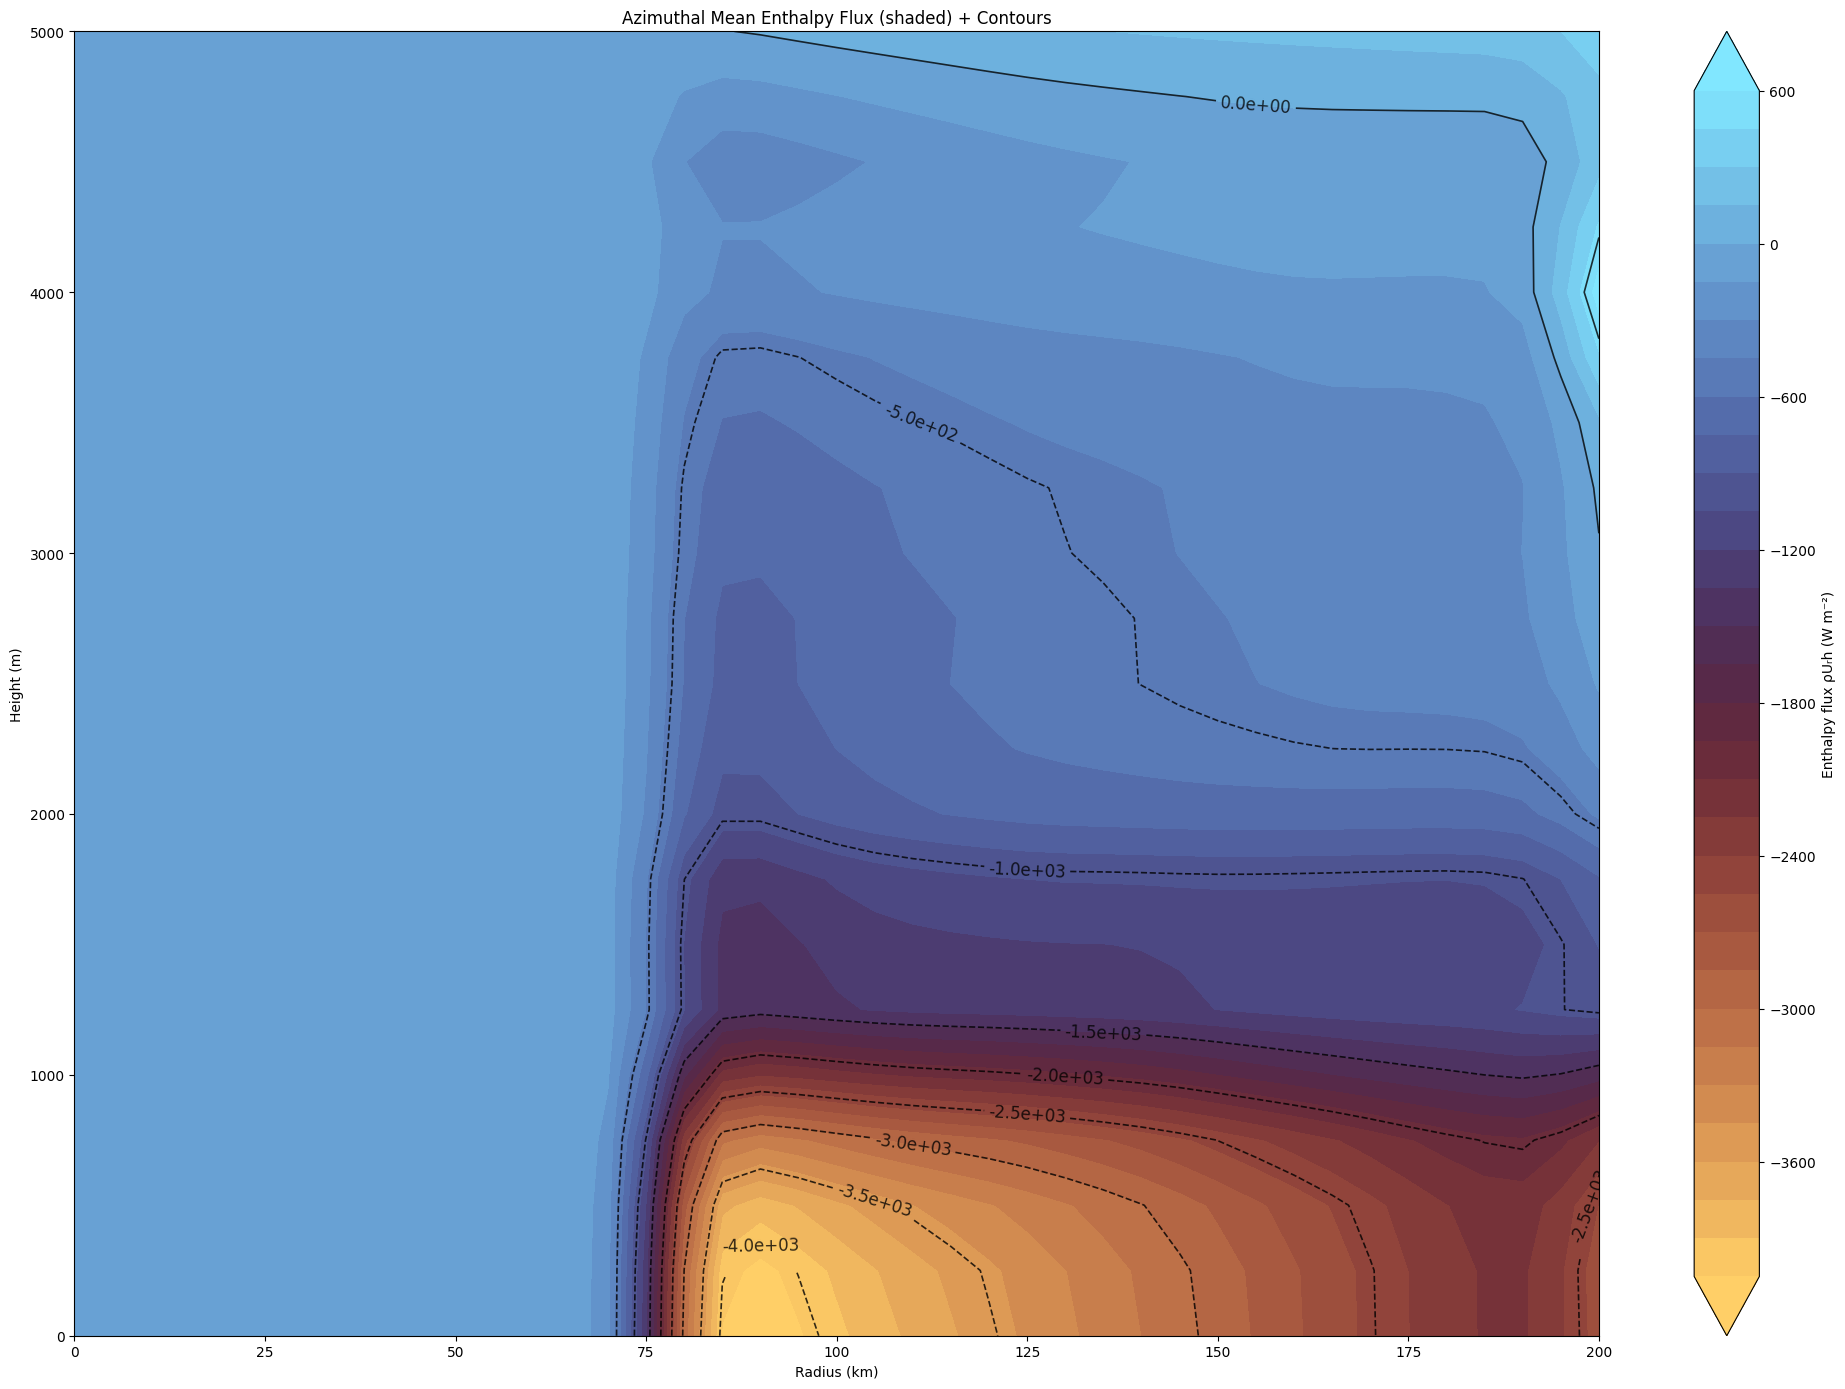

rho3d min/max: 0.08924045 1.1561161
Ur min/max: -77.0023640967647 55.980410632068484
h3d min/max: 194764.45 358616.12


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# (same setup as your code)
r_bins = np.arange(0, 200e3 + 5e3, 5e3)
z_bins = np.arange(0, 5000 + 250, 250)

# initialize storage arrays
mean_Ur = np.zeros((len(z_bins), len(r_bins)))
mean_rho = np.zeros_like(mean_Ur)
mean_h = np.zeros_like(mean_Ur)
mean_flux = np.zeros_like(mean_Ur)

for iz in range(len(z_bins)):
    mask_z = (z_idx == iz)
    for ir in range(len(r_bins)):
        mask = mask_z & (r_idx == ir)
        if np.any(mask):
            mean_Ur[iz, ir] = np.nanmean(Ur[mask])
            mean_rho[iz, ir] = np.nanmean(rho3d[mask])
            mean_h[iz, ir] = np.nanmean(h3d[mask])
            mean_flux[iz, ir] = np.nanmean(rho3d[mask] * Ur[mask] * h3d[mask])

# --- Smooth for cleaner contours ---
mean_flux_smooth = gaussian_filter(mean_flux, sigma=1.0)

mean_flux_smooth = mean_flux_smooth / 1000

# --- Plot ---
fig, ax = plt.subplots(figsize=(20, 14))

# filled contours (enthalpy flux)
cf = ax.contourf(
    r_bins / 1000, z_bins, mean_flux_smooth,
    levels=40,
    cmap="managua",
    extend="both"
)

# contour lines (same field)
cs = ax.contour(
    r_bins / 1000, z_bins, mean_flux_smooth,
    levels=10,
    colors="k",
    linewidths=1.2,
    alpha=0.8
)
ax.clabel(cs, fmt="%.1e", fontsize=12, inline=True)

plt.colorbar(cf, ax=ax, label="Enthalpy flux ρUᵣh (W m⁻²)")
ax.set_xlabel("Radius (km)")
ax.set_ylabel("Height (m)")
ax.set_title("Azimuthal Mean Enthalpy Flux (shaded) + Contours")
plt.tight_layout()
plt.show()

print("rho3d min/max:", np.nanmin(rho3d), np.nanmax(rho3d))
print("Ur min/max:", np.nanmin(Ur), np.nanmax(Ur))
print("h3d min/max:", np.nanmin(h3d), np.nanmax(h3d))
